In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter

from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)

In [4]:
y.head()

,0
Date,
2005-08-24,3.12857
2005-08-25,3.23000
2005-08-26,3.23714
2005-08-27,3.24429
2005-08-28,3.25143


In [5]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]


# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


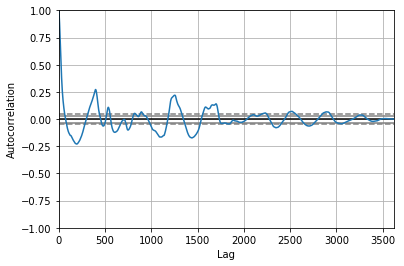

In [6]:
# no clear trend from the graph above, need to try d of different values.
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(train1_y)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


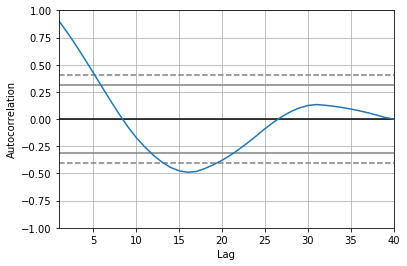

In [7]:
autocorrelation_plot(train1_y[:40])

In [8]:
# the above plot shows the possible significant AR term may be 5
# anyway, just tune the possible choices
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(train1_y2.values, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4017
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2390.608
Method:                       css-mle   S.D. of innovations              0.439
Date:                Wed, 05 Sep 2018   AIC                           4795.216
Time:                        02:58:21   BIC                           4839.304
Sample:                             1   HQIC                          4810.841
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.052     -0.007      0.994      -0.103       0.102
ar.L1.D.y      0.9336      0.016     59.317      0.000       0.903       0.964
ar.L2.D.y    5.48e-05      0.022      0.003      0.9

In [10]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

def evaluate_arima_model1(dataset, p,d,q):
    # fit model
    model = ARIMA(dataset.values, order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    y_pred1=[]
    for t in range(test1_y.shape[0]):
        yhat = model_fit.forecast()[0][0]
        y_pred1.append(yhat)
    error = sqrt(mean_squared_error(val1_y, y_pred1))
    return error

In [10]:
## tune the parameters by rmse
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score=100000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    rmse = evaluate_arima_model1(dataset, p,d,q)
                    if rmse < best_score:
                        best_score = rmse
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' RMSE:',rmse)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') RMSE:',best_score)


In [ ]:
p_values = [1,3,7,9]
d_values = range(0, 3)
q_values = range(0, 5)
evaluate_models(train1_y, p_values, d_values, q_values)

1 , 0 , 0  RMSE: 10.03384360922473
1 , 0 , 1  RMSE: 10.05200638344834
1 , 0 , 2  RMSE: 10.088880341847268
1 , 0 , 3  RMSE: 10.065493202593318
1 , 0 , 4  RMSE: 10.075986514377025
1 , 1 , 0  RMSE: 10.105110229999624
1 , 1 , 1  RMSE: 10.104803621656574
1 , 1 , 2  RMSE: 10.104324970808438
1 , 1 , 3  RMSE: 10.103611111311357
1 , 1 , 4  RMSE: 10.110223235098854
1 , 2 , 0  RMSE: 10.11182966066178


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 1  RMSE: 10.111829660444279


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 2  RMSE: 10.111829658982405


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 3  RMSE: 10.111829660339806


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 4  RMSE: 10.111830378899747
3 , 0 , 0  RMSE: 10.077030084122118


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 , 0 , 1  RMSE: 10.083081066901084


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 , 0 , 2  RMSE: 10.083405591319217
3 , 0 , 3  RMSE: 10.084300644926271
3 , 0 , 4  RMSE: 10.08726049100803
3 , 1 , 0  RMSE: 10.104334545614117
3 , 1 , 1  RMSE: 10.081278313807985
3 , 1 , 2  RMSE: 10.079547806156079
3 , 1 , 3  RMSE: 10.080352481541674
3 , 1 , 4  RMSE: 10.111361954649398
3 , 2 , 0  RMSE: 10.111829661705015


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 1  RMSE: 10.111829664653778


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 2  RMSE: 10.111829659600094


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


3 , 2 , 3  RMSE: 10.111829657897443
3 , 2 , 4  RMSE: 10.1227878684446


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


7 , 0 , 1  RMSE: 10.085547712443407
7 , 0 , 2  RMSE: 10.072477985211458
7 , 0 , 3  RMSE: 10.09379862202782


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodel

7 , 1 , 0  RMSE: 10.109598295879907
7 , 1 , 1  RMSE: 10.109607578603145
7 , 1 , 2  RMSE: 10.108952337344935
7 , 1 , 3  RMSE: 10.106724616648997


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


7 , 1 , 4  RMSE: 10.12089696408284
7 , 2 , 0  RMSE: 10.111828856327202
7 , 2 , 1  RMSE: 10.111828856125836
7 , 2 , 2  RMSE: 10.11182885609232
7 , 2 , 3  RMSE: 10.111828858004095


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


7 , 2 , 4  RMSE: 10.107753173363841
9 , 0 , 1  RMSE: 10.083658233268775


In [11]:
## by validation set and RMSE we get (1,0,0), check this model, quite poor AIC
model = ARIMA(train1_y2.values, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4018
Model:                     ARMA(1, 0)   Log Likelihood               -5670.578
Method:                       css-mle   S.D. of innovations              0.992
Date:                Wed, 05 Sep 2018   AIC                          11347.155
Time:                        02:58:35   BIC                          11366.051
Sample:                             0   HQIC                         11353.852
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2530      4.696      1.757      0.079      -0.952      17.458
ar.L1.y        0.9969      0.001    855.820      0.000       0.995       0.999
                                    Roots           

In [10]:
## now model selection via AIC
def evaluate_arima_model2(dataset, p,d,q):
    # fit model
    model = ARIMA(dataset.values, order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [ ]:
p_values = [0]
d_values = [0,2]
q_values = [13,14,15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

In [13]:
p_values = [1]
d_values = [0,2]
q_values = [13,14,15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 13  AIC: 3040.6277190449655


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 14  AIC: 3041.3478579625425


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 15  AIC: 3041.972256208728


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 2 , 14  AIC: 3107.04911893767
1 , 2 , 15  AIC: 3109.0491149891986
Best ARIMA ( 1 , 0 , 13 ) AIC: 3040.6277190449655


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [17]:
p_values = [1]
d_values = [0,1]
q_values = [12,14]
evaluate_models2(train1_y2, p_values, d_values, q_values)

1 , 0 , 12  AIC: 3559.695741732131


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 0 , 14  AIC: 3041.3478579625425


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1 , 1 , 12  AIC: 3476.675938444322
1 , 1 , 14  AIC: 3039.6810607036296
Best ARIMA ( 1 , 1 , 14 ) AIC: 3039.6810607036296


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [19]:
p_values = [1]
d_values = [1]
q_values = [15]
evaluate_models2(train1_y2, p_values, d_values, q_values)

1 , 1 , 15  AIC: 3040.4316560984407
Best ARIMA ( 1 , 1 , 15 ) AIC: 3040.4316560984407


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [12]:
## now by rmse we otbtain(1,0,0), by aic we have (11,0,4) compare the performance of the two 
## on all training set including validation, and compare reuslts on test set
#model1 = ARIMA(train1_y2.values, order=(1,0,0))
#model_fit1 = model1.fit(disp=0)
#print(model_fit1.summary())

#model2 = ARIMA(train1_y2.values, order=(1,1,14))
#model_fit2 = model2.fit(disp=0)
#print(model_fit2.summary())

from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)



In [12]:
train1 = train2_y2.values
test1 = test2_y.values

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast()
    yhat = output[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history = history[1:]

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.889818728243131
1.79795963563615
1.7068270382047028
1.6561646935406793
1.890987212098561
1.986187363774849
2.079804799489002
2.1750198409286057
2.268315013198376
2.362820457657078
2.4245136176985724
2.4137995460569535
2.442193432318849
2.46913607488965
2.498065751899318
2.5249354440392704
2.5523223506729793
2.535617366459767
2.858643203574759
3.015093502352417
3.170256983891252
3.326635853730823
3.481310674920613
3.637336623653591
3.711479167638517
3.6686975750498423
3.6870478722649485
3.7041928861442206
3.72313993263736
3.7400614806645676
3.7573584286088235
3.731302880756271
3.987888820954884
4.105683718491153
4.222380263758518
4.340079202991185
4.456369078941469
4.573451958125819
4.635311574442981
4.985899960215701
5.1964856813734555
5.406518296575288
5.617072077062733
5.8269121670803425
6.036483694054695
6.101267780649302
6.38368333199445
6.559705923350321
6.7354399231974265
6.911327160470911
7.087091485755005
7.2617828872823385
7.311046831691374
7.3186187753503225
7.3475106765930

In [13]:
mae1 = mean_absolute_error(test2_y, predict)
rmse1 = sqrt(mean_squared_error(test2_y, predict))

print(mae1,rmse1)

0.0579874617485389 0.14327692728534802


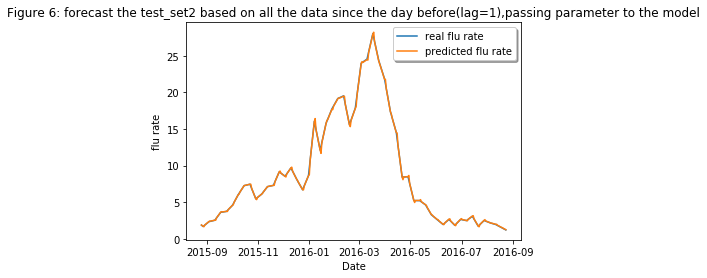

In [14]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 6: forecast the test_set2 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [14]:
train1 = train2_y2.values[:3653-4]
test = y.values[3653-4:]
test1 = test2_y.values

history = [x for x in train1]
predict2 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=5)
    yhat = output[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2.7219894794817563
1
2.1088761120981263
2
2.027316320888233
3
1.9845570639207557
4
1.9335977374731528
5
1.8891177381367859
6
1.8303271455918277
7
1.7805736179873597
8
2.55414564466153
9
2.661947025912756
10
2.7208799270235855
11
2.772134729447704
12
2.836414519487162
13
2.890923022416073
14
2.935358857721768
15
2.7823181584955163
16
2.8190802414907683
17
2.8097687876896993
18
2.7928556098754176
19
2.782119779029813
20
2.7572521307076796
21
2.7418862518103686
22
3.702471189105356
23
3.871781880132006
24
3.941588580197655
25
4.005095372127746
26
4.081476124664916
27
4.148006934607196
28
4.204530917112028
29
3.937231305338594
30
3.962612423900962
31
3.9442939995839574
32
3.9191894850514575
33
3.8991589550701664
34
3.8647796775619154
35
3.8429753450587585
36
4.635354742948465
37
4.763377568920852
38
4.820719113867721
39
4.871981612902487
40
4.935675784034078
41
4.990610639434561
42
5.0371041607521985
43
5.912093961353388
44
6.129358079911973
45
6.195080511746474
46
6.254814448042982
47
6.3

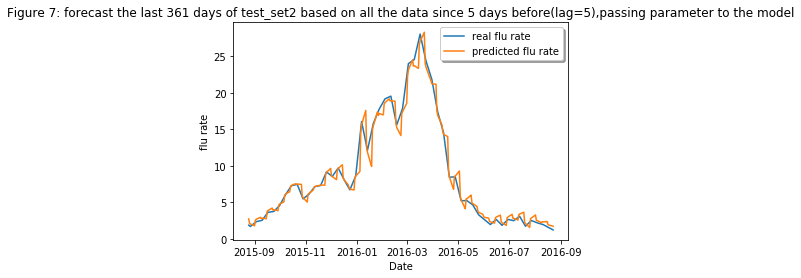

In [16]:

# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 7: forecast the last 361 days of test_set2 based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [17]:
## lag=10
train1 = train2_y2.values[:3653-9]
test = y.values[3653-9:]
test1 = test2_y.values

history = [x for x in train1]
predict3 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=10)
    yhat = output[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3.4989719507112955
1
3.5127453064893857
2
3.5160663744276293
3
3.5126791059254927
4
3.4924453102275157
5
3.481009716551969
6
2.654095316886207
7
2.6330483412494523
8
2.6018352697834124
9
2.5594647183472543
10
2.5728984765596747
11
2.564612283439757
12
2.564046287760684
13
3.6441618744541446
14
3.7058689173870816
15
3.745041704261185
16
3.773122394288632
17
3.7579047622476898
18
3.7288252038818883
19
3.709097755739275
20
3.4390723098515004
21
3.4505321756116283
22
3.4510595212987956
23
3.4410023061326247
24
3.4533393610154612
25
3.4444265739988014
26
3.445382158177791
27
4.728539554909947
28
4.800093083306755
29
4.847023130710454
30
4.884980915387814
31
4.868113970662358
32
4.839144836690058
33
4.821332670278065
34
4.385416819856738
35
4.388427753840343
36
4.382482428459565
37
4.367130207049792
38
4.382325311048582
39
4.377444055378503
40
4.383031587077124
41
5.454082668538604
42
5.5106453526658665
43
5.547060019335815
44
5.574533975041229
45
5.559158675483479
46
5.533109315081754
47
5.

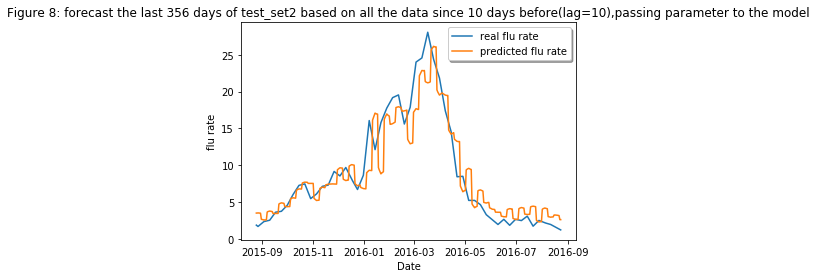

In [18]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 8: forecast the last 356 days of test_set2 based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [19]:
## lag=14
train1 = train2_y2.values[:3653-13]
test = y.values[3653-13:]
test1 = test2_y.values

history = [x for x in train1]
predict4 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=14)
    yhat = output[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3.7604422562954998
1
3.7544814184807396
2
3.757562556587924
3
4.13783039853355
4
4.14594899998489
5
4.140745691496684
6
4.130336451221292
7
4.115072165753461
8
4.101193883739201
9
4.096637927411667
10
3.242740734118724
11
3.2713304799215193
12
3.278263485963446
13
3.2740905294087312
14
3.2680144678982743
15
3.2668537141895326
16
3.2776242889006517
17
4.391168802303512
18
4.385951290138061
19
4.372591745211755
20
4.3581606755666655
21
4.336201439636418
22
4.3121403214444625
23
4.296698102366899
24
4.0201061570092
25
4.047088560179451
26
4.0514360323292244
27
4.045905729436807
28
4.040598176464768
29
4.0428043420675195
30
4.054944095892073
31
5.377933820885006
32
5.368720878624109
33
5.352504844140311
34
5.336578713413407
35
5.315159551462604
36
5.2937138639746095
37
5.279210027119515
38
4.831500677228819
39
4.85858449663355
40
4.864710511696825
41
4.860002957676006
42
4.858553841278791
43
4.86371892199178
44
4.880778086034476
45
5.984746545208246
46
5.974139594823582
47
5.95900727985919

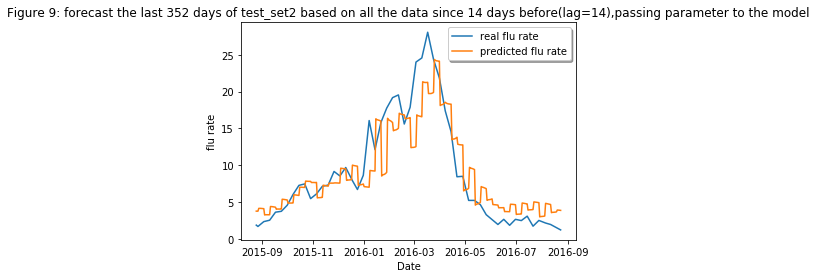

In [20]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 9: forecast the last 352 days of test_set2 based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [21]:
## lag=28
train1 = train2_y2.values[:3653-27]
test = y.values[3653-27:]
test1 = test2_y.values

history = [x for x in train1]
predict5 = list()
training_mod = sm.tsa.SARIMAX(history, order=(1,1,14))
training_res = training_mod.fit()

count =0

for t in range(len(test1)):
    model = sm.tsa.SARIMAX(history, order=(1,1,14))
    model_fit = model.filter(training_res.params)
    output = model_fit.forecast(steps=28)
    yhat = output[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5.6071655850755375
1
5.599932438910046
2
5.599477871835388
3
5.788371592128018
4
5.783083650426314
5
5.780500947982276
6
5.769184108590575
7
5.762619307579189
8
5.748343807622337
9
5.744189473340209
10
5.7523653429364385
11
5.751546624709378
12
5.756029605571504
13
5.751290580357434
14
5.750755444750593
15
5.740112601643094
16
5.738678513277376
17
5.94205087774816
18
5.938250125932863
19
5.937595088174666
20
5.928076407918949
21
5.923191218559625
22
5.9095369796490695
23
5.906584613638431
24
5.427389432156772
25
5.429886787464034
26
5.439440971728737
27
5.439066767145499
28
5.442385136260769
29
5.43576709133833
30
5.435971151306914
31
6.045462601301876
32
6.037786229167886
33
6.030470607071004
34
6.014611480332125
35
6.00377446420031
36
5.987219371183013
37
5.981599663083877
38
5.817605214886498
39
5.8198244537529265
40
5.828895421068601
41
5.828768310724084
42
5.8325841193769445
43
5.827055331900479
44
5.8278276613511775
45
6.553845998503993
46
6.545142344865588
47
6.536413468123192
4

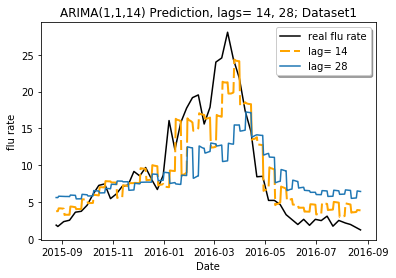

In [30]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate', color='black')
ax.plot(date[3653:],predict4,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 14')
ax.plot(date[3653:],predict5,label='lag= 28')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMA(1,1,14) Prediction, lags= 14, 28; Dataset1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arima1428_test1.pdf", bbox_inches='tight')

plt.show()

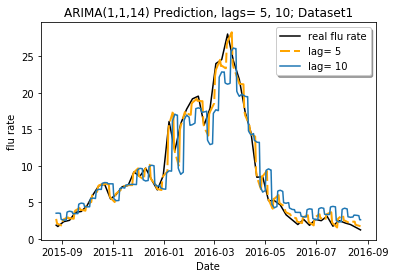

In [31]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:],df.y[3653:4018],label='real flu rate', color='black')
ax.plot(date[3653:],predict2,dashes=[5,2,20,2], linewidth=2,color='orange',label='lag= 5')
ax.plot(date[3653:],predict3,label='lag= 10')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("ARIMA(1,1,14) Prediction, lags= 5, 10; Dataset1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("arima510_test1.pdf", bbox_inches='tight')

plt.show()

In [13]:
arimax_ex_t1 = pd.read_csv('ARIMAX_EN_t1.csv',header=None)

In [22]:
arimax_ex_t1[1].head()

0    1.282581
1    1.295108
2    1.362307
3    1.403887
4    2.764880
Name: 1, dtype: float64

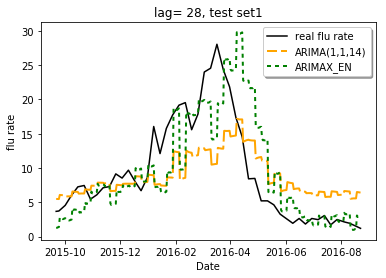

In [26]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653+27:],df.y[3653+27:4018],label='real flu rate',color='black')
ax.plot(date[3653+27:],predict5,label='ARIMA(1,1,14)',dashes=[5,2,20,2], linewidth=2,color='orange')
ax.plot(date[3653+27:],arimax_ex_t1[1].values,label='ARIMAX_EN',dashes=[2,2], linewidth=2,color='green')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("lag= 28, test set1")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("ar_test1.pdf", bbox_inches='tight')

plt.show()

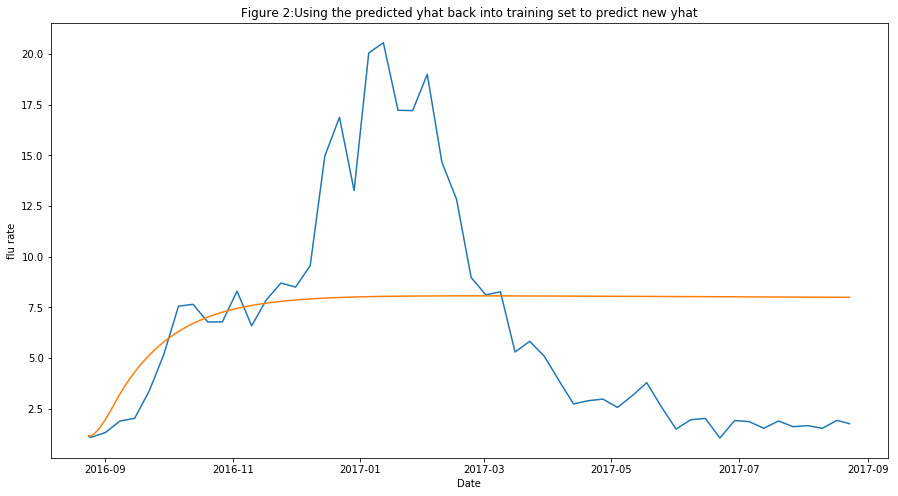

In [21]:
## results of above iteratively prediction 
predict2=   [1.17728183,1.1650975,1.22402906,1.30387754,1.40379864,1.52525009,1.66675996,1.81504843,1.96891683,2.14070386,2.31727531,2.49810602,2.68367832,2.87322547,3.05615562,3.23269185,3.40301013,3.56737837,
            3.72600493,3.87908551,4.02681623,4.16940779,4.30704519,4.43988732,4.56811368,4.69187792,4.81133435,4.92662897,5.0379172,5.14532646,5.24900171,5.34905634,5.44563163,5.53885598,5.62882835,5.71567021,
            5.79949884,5.88040801,5.95850058,6.03387403,6.10661813,6.17684649,6.24463225,6.3100625,6.37321128,6.43416407,6.49299116,6.54975336,6.60453004,6.65739214,6.70840892,6.75764423,6.80516038,6.85101357,
            6.89527966,6.93799121,6.9792067,7.01898596,7.05737272,7.09442454,7.13017917,7.16467587,7.19796026,7.23007614,7.26106567,7.29096745,7.31981179,7.3476421,7.37449125,7.40040076,7.42539772,7.4495079,
            7.47276511,7.49518339,7.51681312,7.53767761,7.5578018,7.57722755,7.59596212,7.61403245,7.63146546,7.64827677,7.66448926,7.68012224,7.69518653,7.70971149,7.7237178,7.73722875,7.75025443,7.76283067,
            7.77495961,7.78662756,7.79787676,7.8087204,7.81918005,7.82926522,7.83896993,7.84831432,7.85733191,7.86602693,7.87440643,7.88247713,7.89024994,7.89773286,7.90493879,7.91188794,7.91857762,7.92501754,
            7.93122102,7.93717911,7.94291686,7.94844357,7.95376268,7.95887924,7.9638022,7.96853585,7.97309665,7.97748366,7.98170495,7.98575358,7.98964585,7.99339632,7.99700377,8.0004757,8.00381079,8.00699767,
            8.0100586,8.01299588,8.01581013,8.01849895,8.02109358,8.02358343,8.02597851,8.02827295,8.03048132,8.0325937,8.03461359,8.03652895,8.03836697,8.04013177,8.04182591,8.04343626,8.04497332,8.04644759,
            8.0478535,8.04919091,8.05046732,8.05168372,8.05284112,8.0539425,8.05499303,8.05599525,8.05694324,8.05783346,8.05867908,8.05948112,8.06023969,8.06166986,8.06232502,8.06294728,8.06353482,8.06408609,
            8.06462251,8.06511224,8.06556895,8.06599272,8.06643102,8.0668379,8.06721485,8.0675512,8.06785085,8.06811622,8.06835766,8.06855108,8.06872075,8.06887012,8.06898941,8.06908777,8.06917064,8.06923464,
            8.06926215,8.06927613,8.06927207,8.0692519,8.06920781,8.06915344,8.06908439,8.06900123,8.0689029,8.06879012,8.06866637,8.06853597,8.06838647,8.06822614,8.06805557,8.0678727,8.06768174,8.06748026,
            8.06727055,8.06705528,8.06683198,8.06659646,8.066333,8.06606185,8.06578928,8.06551131,8.06523681,8.06495493,8.06465493,8.06436734,8.06407241,8.06376878,8.06346011,8.06314188,8.06282662,8.06251595,
            8.06220489,8.06188895,8.06156435,8.06123498,8.06089933,8.06055168,8.06020573,8.05985295,8.05950727,8.05915821,8.05880513,8.05844789,8.0580849,8.05771835,8.05734835,8.05696829,8.05658208,8.05619284,
            8.05579503,8.0553998,8.05500211,8.05459521,8.05418114,8.05376682,8.05335064,8.05292787,8.05250264,8.05207536,8.05165028,8.05122104,8.05079119,8.05036159,8.0499374,8.04950946,8.04908756,8.04866931,
            8.04824352,8.04824352,8.04781545,8.04738618,8.04695827,8.04652839,8.04609382,8.04565872,8.04522841,8.04479708,8.04436236,8.04392636,8.04348847,8.0430457,8.04260009,8.04215732,8.04171409,8.04126991,
            8.04082506,8.04036924,8.03991311,8.03945186,8.03899026,8.0385241,8.03805978,8.03759527,8.03713701,8.0366785,8.03622179,8.03576518,8.03531057,8.03485451,8.03439814,8.03394605,8.03349009,8.03303669,
            8.0325825,8.03212956,8.03167578,8.03118689,8.03069731,8.03021033,8.0297232,8.02923405,8.0287449,8.02828935,8.02785277,8.0274165,8.02698442,8.02655109,8.02611752,8.02567091,8.02520429,8.02475239,
            8.02430001,8.02384481,8.0233885,8.02293279,8.02248155,8.02201534,8.0215427,8.02106612,8.02058856,8.02011103,8.01964331,8.01918201,8.0187206,8.01823212,8.01774657,8.01726176,8.01679237,8.01630756,
            8.01582411,8.01533957,8.01487555,8.0144132,8.01395223,8.01348291,8.01301586,8.01255409,8.01209319,8.0116609,8.01122774,8.01079255,8.01035125,8.00991384,8.00947302,8.00903171,8.0085793,8.00812626,
            8.00767213,8.00721728,8.0067619,8.0063033,8.00587837,8.0054439,8.00501734,8.0045906,8.00416213,8.00370799,8.00325371,8.0027795,8.00230673,8.00183548,8.00136777,8.00088527,8.00041694,7.99995121,
            7.9994701,7.99899079,7.9985036,7.9980142,7.99753405]
mae2 = mean_absolute_error(test1_y, predict2)
rmse2 = sqrt(mean_squared_error(test1_y, predict2))

print(mae2,rmse2)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],date[4018:],predict2)
plt.title("Figure 2:Using the predicted yhat back into training set to predict new yhat")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [27]:
# obviously the way of obtaining prediction values is wrong, try other ways
from statsmodels.tsa.arima_model import ARMAResults

train1 = train1_y2.values

test1 = test1_y.values

history = [x for x in train1]
predict3 = list()
for t in range(len(test1)):
    model = ARIMA(history, order=(1,1,14))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    print(yhat)
    predict3.append(yhat)
    obs = test1[t]
    history.append(obs)

mae1 = mean_absolute_error(test1_y, predict3)
rmse1 = sqrt(mean_squared_error(test1_y, predict3))

print(mae1,rmse1)



/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.17728183]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.1140093]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.10086218]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.18011196]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.21406008]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.25024906]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.28363876]
[1.31984028]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.35230127]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.37235281]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.51248622]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.59354508]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.67684366]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.75730126]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.84059901]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.92017215]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.94630637]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.95622044]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.97442603]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.99490015]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.0124984]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.0329874]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.04971824]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.04633568]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.43039809]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.62281329]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.81741131]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.00926524]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.20384969]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.39477671]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.47932696]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.90509481]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.16322079]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.4234698]
[4.6810598]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.94131078]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.19795381]
[5.27345078]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.86794388]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.20596364]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.54602103]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.88351573]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.22364241]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.56014668]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.67469157]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.58615903]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.59851249]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.61301254]
[7.62487873]
[7.63942889]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.65028872]
[7.60850683]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.40625754]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.28145335]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.15873027]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.03341843]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.91075541]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.78446397]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.75100785]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.78654828]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.78750527]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.79051744]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.79093751]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.79401306]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.79345872]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.81039675]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.22002605]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.43518944]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.65234618]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.86700248]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.08422609]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.29788348]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.38543727]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.81559343]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.5709189]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.32833792]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.0831519]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.84059868]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.59443911]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.45378413]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.95716478]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.13942176]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.3236131]
[7.50536206]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.68961126]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.87032902]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.01139582]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.10280056]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.22092685]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.34109557]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.45874662]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.57896196]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.69558748]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.688211]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.64225392]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.61310607]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.58593609]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.55627726]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.52918917]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.49855051]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.49187561]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.79713685]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.94803477]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.10089456]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.25127196]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.40421496]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.55359306]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.62419366]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[11.07923015]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[11.8499825]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[12.6223594]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.39242681]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[14.16503091]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[14.93424394]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.23894395]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.47525425]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.74729439]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.0216332]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.29311631]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.56756455]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.83813013]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.82913779]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.82425109]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.30788677]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[14.79361272]
[14.27642621]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.7623396]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.24453427]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.03146878]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.15905844]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.12635614]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.09596373]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.0626509]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[19.03235981]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[19.99803623]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.51073313]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.14206122]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.21383756]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.28867317]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.35987969]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.43482823]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.50517451]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[20.32414403]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[19.57503567]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[19.09806623]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.62372854]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.14600585]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.67191722]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.19351391]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.07404723]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.18521754]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.18147655]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.18019202]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.17573349]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.17455786]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.16930928]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.22541789]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.67764978]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.93220092]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.18930591]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.44332836]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.70050726]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[18.95354659]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[19.04520088]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.73348992]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[17.11434126]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[16.49738465]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.87743863]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[15.26067349]
[14.64009692]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[14.34144934]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[14.12650724]
[13.86411762]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.60409395]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.34116647]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[13.08114754]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[12.81730325]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[12.83818015]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[11.72496421]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[11.17291437]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[10.62352756]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[10.07100694]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[9.52156331]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.96812949]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.72719502]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.73129331]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.60897637]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.48908401]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.36626104]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.24642478]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.12268938]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.17663204]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.1618834]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.1826783]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.20597566]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.22622846]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.24957524]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.26894442]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[8.25756164]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.43327285]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[7.00830543]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.58592209]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[6.16045168]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.73808728]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.3117259]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.13708049]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.46063843]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.53573119]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.61310542]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.68759468]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.76506444]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.83865619]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.94732305]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.62812453]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.52184709]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.41812516]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.31132193]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.20759608]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.09993991]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[5.0097304]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.76325675]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.5911652]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.42162149]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.24899552]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[4.07939915]
[3.90594071]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.87231058]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.57914051]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.41435399]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.25210033]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.08679681]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.92452157]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.75835003]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.70318068]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.8036445]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.82587035]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.85063044]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.87235368]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.89706038]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.91791997]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.95169293]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.93920166]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.95010492]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.96353431]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.97389155]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.98729793]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.99680163]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.98758693]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.88142964]
[2.82228638]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.76568365]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.70598282]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.6493499]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.58881935]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.56802994]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.7489113]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.8297715]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.91312403]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.99341467]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.07675347]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.15620828]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.20026206]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.33926494]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.43153784]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.52631718]
[3.61804473]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.71278886]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.80365854]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.82503538]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.46793567]
[3.29740176]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[3.12944384]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.95833073]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.79034078]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.61839808]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.53709374]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.30754425]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.14985956]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.99474674]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.83651118]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.68135269]
[1.52226449]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.49005883]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.65060395]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.71579738]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.78349712]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.84812318]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.91576751]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.97954988]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.02142086]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.9987163]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.00819769]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.02022091]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.02914804]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.04111229]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.04919509]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.03556197]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.77524671]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.63612885]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.49969084]
[1.36003647]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.2234806]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.08302377]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.0294958]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.32486461]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.44716991]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.57197389]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.69372012]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.81845853]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.93933651]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[2.01463674]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.92405312]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.91642556]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.91138199]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.90318395]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.898046]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.88900349]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.85372315]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.79642914]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.74871629]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.70358145]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.65533184]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.61011541]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.56099462]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.55588226]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.66117465]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.71208589]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.7655344]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.81587657]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.8692553]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.91875011]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.94290668]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.83945349]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.79892225]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.76096754]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.71988458]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.6818628]
[1.63991998]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.61245878]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.65364714]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.66027143]
[1.66940873]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.67544437]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.68451539]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.68971717]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.70445385]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.65202981]
[1.63296395]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.61643487]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.59677913]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.58018808]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.55970543]
[1.54539127]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.66959385]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.72480057]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.78245778]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.83707137]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.89466903]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.94843376]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.97831339]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.89388412]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.86625329]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.84115757]


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


[1.81296006]
[1.78776963]
0.039292803977595686 0.10759165634668226


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


NameError: name 'predict3' is not defined

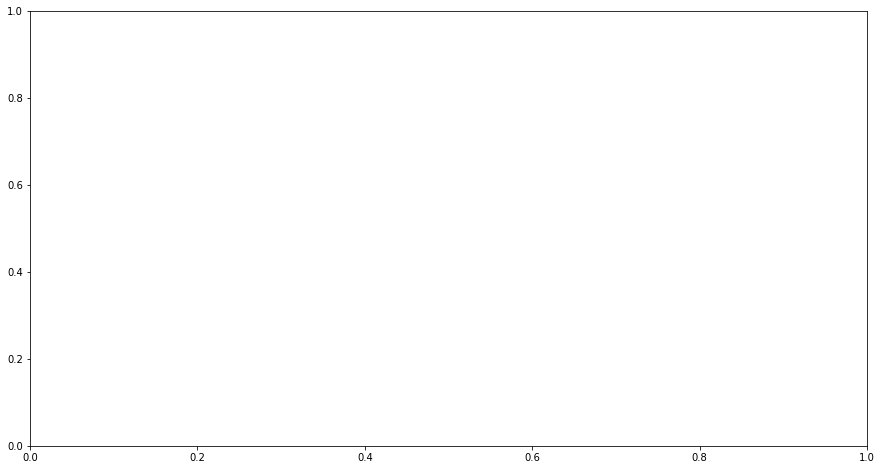

In [25]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],date[4018:],predict3)
plt.title("Figure 1:put back test set")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()